In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.feynnet

In [3]:
use_signal = [ i for i, m in enumerate(module.feynnet_signal_list) if m in module.signal_list ]

In [30]:
# signal = ObjIter([])
signal = ObjIter([Tree(f, report=False, altfile='test_{base}') for f in tqdm(module.signal_list)])

100%|██████████| 3/3 [00:15<00:00,  5.10s/it]


In [31]:
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List, altfile='test_{base}')])


100%|██████████| 16/16 [00:09<00:00,  1.64it/s]


In [32]:
model = eightb.models.feynnet_mx_reweight

In [33]:
model = eightb.models.feynnet_mx_reweight
(signal + bkg).apply( lambda t : eightb.load_yy_quadh_ranker(t, model.storage.replace('weaver/','weaver/analysis/')), report=True, parallel=True)

100%|██████████| 4/4 [04:31<00:00, 67.95s/it] 


[None, None, None, None]

In [34]:
varinfo.X_m =   dict(bins=(400,2000,30), )
varinfo.Y1_m =  dict(bins=(100,1000,30), )
varinfo.Y2_m =  dict(bins=(100,1000,30), )
varinfo.H1Y1_m =   dict(bins=(0,300,30), )
varinfo.H2Y1_m =   dict(bins=(0,300,30), )
varinfo.H1Y2_m =   dict(bins=(0,300,30), )
varinfo.H2Y2_m =   dict(bins=(0,300,30), )


In [35]:
def higgs_m_chi2(t):
    return np.sqrt( ak.sum( (t.higgs_m-125)**2, axis=1 ) )
higgs_m_chi2.bins = (0,300,30)

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


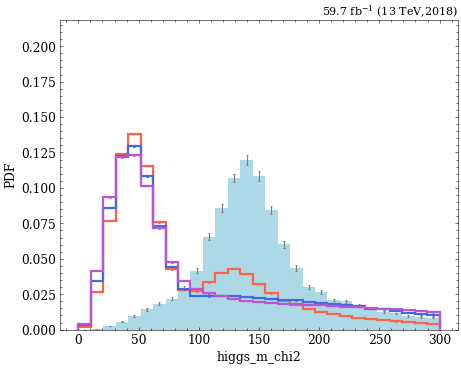

In [38]:
study.quick(
    signal+bkg,
    varlist=[higgs_m_chi2],
    efficiency=True,
)

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


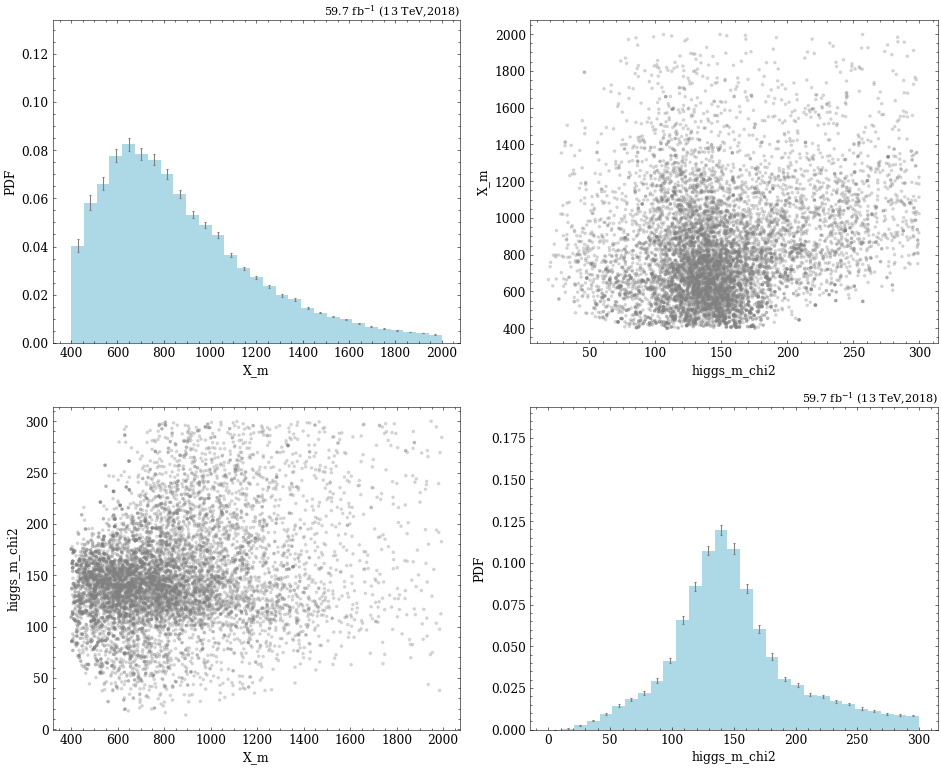

In [41]:
study.pairplot(
    bkg,
    varlist=['X_m',higgs_m_chi2],
    efficiency=True,
)

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


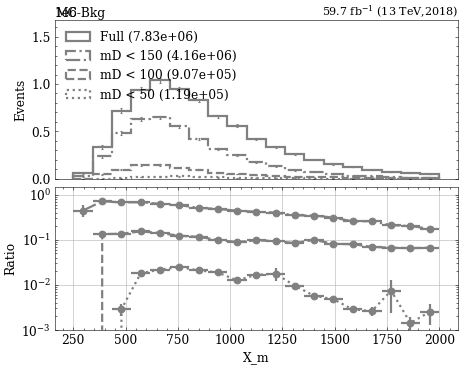

In [69]:
study.compare_masks(
    [],bkg,
    label=['Full','mD < 150','mD < 100','mD < 50'],
    masks =[None, lambda t : higgs_m_chi2(t) < 150, lambda t : higgs_m_chi2(t) < 100, lambda t : higgs_m_chi2(t) < 50],
    varlist=['X_m'],
    binlist=[(250,2000,20)],
    legend=True,

    ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,1.5),
    r_size="90%", 
    # efficiency=True,
)

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


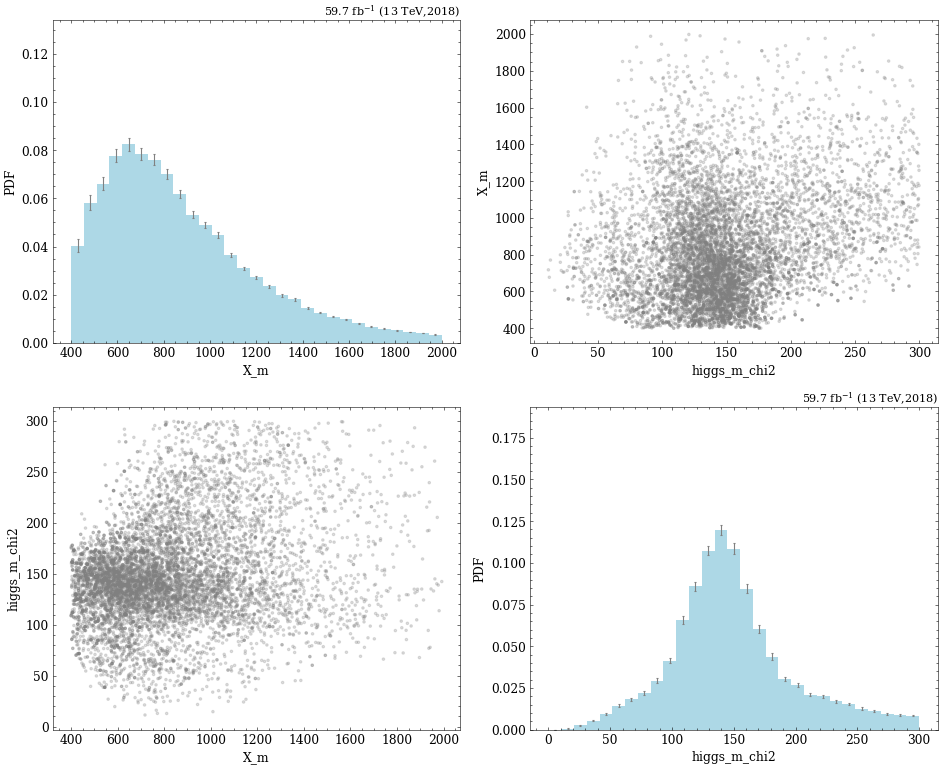

In [27]:
study.pairplot(
    bkg,
    varlist=['X_m', higgs_m_chi2],
)

In [14]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))
partial_signal = signal.apply(EventFilter('partial_eightb', filter=lambda t : t.nfound_select< 8))

100%|██████████| 1/1 [00:06<00:00,  6.29s/it]

x_mean=16.000
x_std=9.522
x_min=0.000
x_max=32.000
y_mean=0.553
y_std=0.208
y_min=0.189
y_max=0.951
x_sum=528.000
y_sum=18.241
area=17.603
ndf=33.000


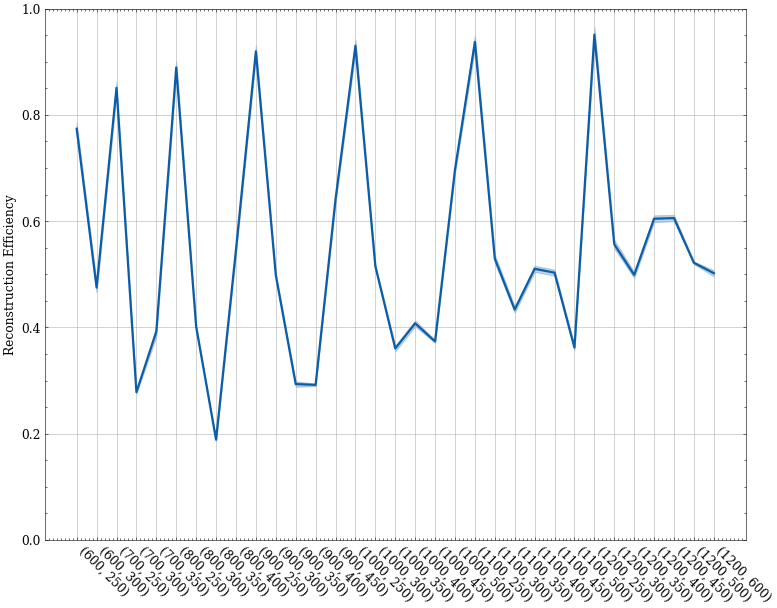

In [15]:
fig, ax = study.get_figax(size=(10,8))

study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    stat_err=lambda h:h.error[-1],
    g_grid=True,

    g_exe=lambda graph, **kwargs: print( f'{graph.stats:0.3f}'),
    g_ylim=(0,1),
    # g_g_label=f'MY={my}',
    # g_xlabel='MX',
    g_legend=True,
    figax=(fig,ax)
)

In [16]:
from utils.ak_tools import ak_argavg

In [17]:
eightb_signal_eff = eightb_signal.apply( lambda t : ak.mean(t.reco_id == 0) ).npy
extrema_signal = [eightb_signal_eff .argmin(), ak_argavg(eightb_signal_eff), eightb_signal_eff.argmax()]
extrema_signal = [7, 30, 26]


In [18]:
eightb_signal_eff[extrema_signal]

array([0.18876178, 0.60577938, 0.95090787])

100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


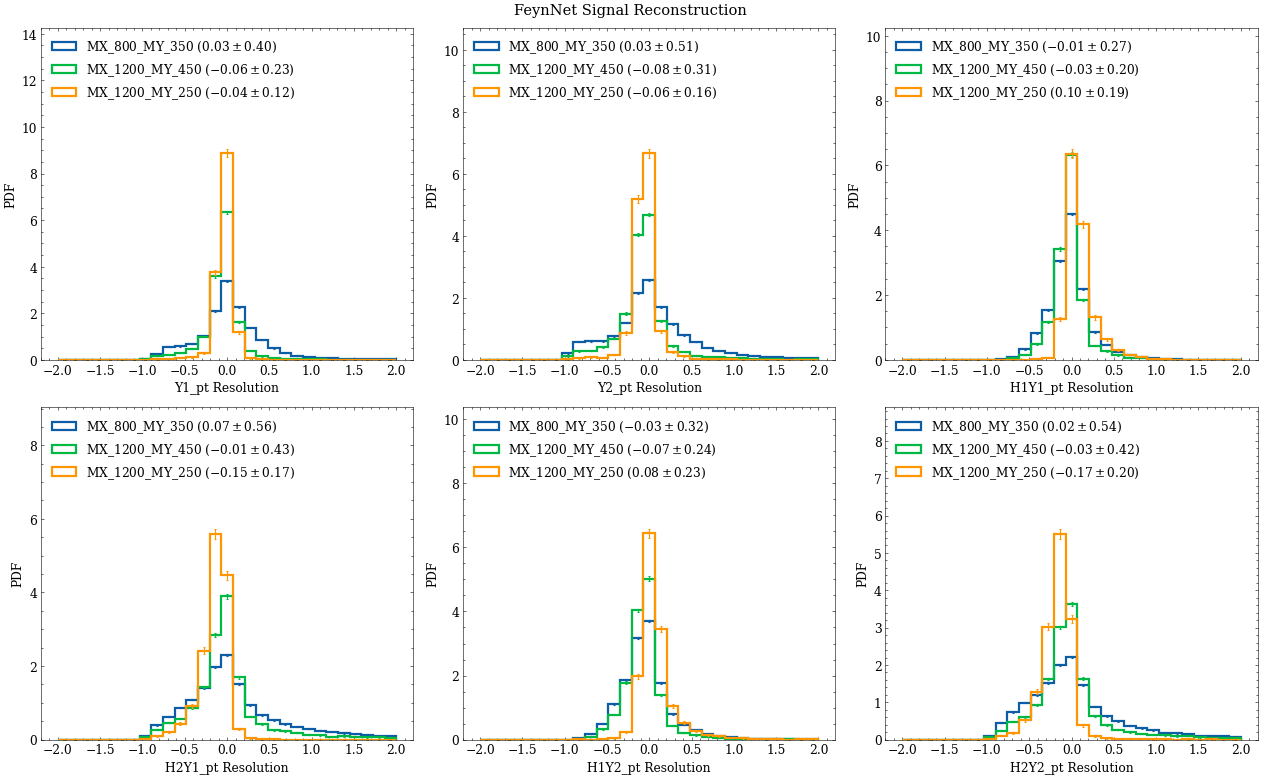

In [19]:
class gen_res(ObjTransform):
    def __init__(self, kin):
        self.kin = kin
    @property
    def xlabel(self): return f'{self.kin} Resolution'
    @property
    def bins(self): return (-2,2,30)
    def __call__(self, t):
        if self.kin is None: return
        return (t[self.kin]-t[f'gen_{self.kin}'])/t[f'gen_{self.kin}']

study.quick(
    eightb_signal[extrema_signal],
    legend=True,
    h_label_stat='${stats.mean:0.2f}\pm{stats.stdv:0.2f}$',
    varlist=[ gen_res(f'{res}_pt') for res in ['Y1','Y2','H1Y1','H2Y1','H1Y2','H2Y2']],
    suptitle='FeynNet Signal Reconstruction',
    h_restrict=True,
    lumi=None,
    density=True,
)

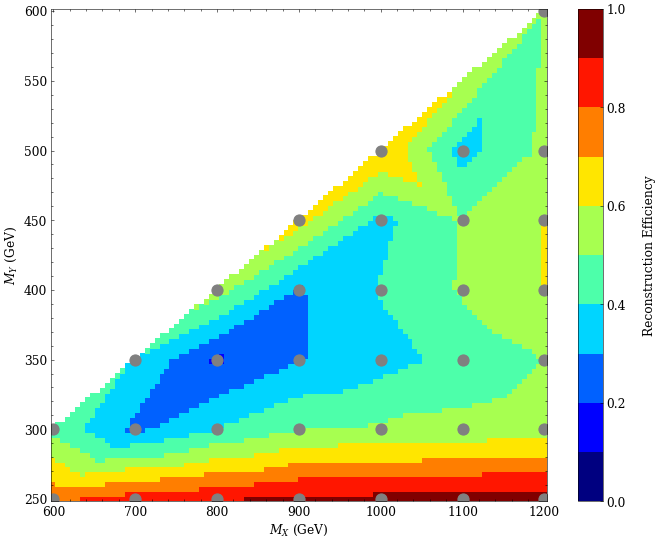

In [21]:
fig, ax = study.get_figax(size=(10,8))

study.mxmy_phase(
    eightb_signal,
    label=signal.mass.list,
    zlabel='Reconstruction Efficiency',
    efficiency=True,

    f_var=lambda t: ak.mean(t.reco_id==0),
    g_cmap='jet',

    xlabel='$M_X$ (GeV)',
    ylabel='$M_Y$ (GeV)',

    # xlim=(550,1250),
    # ylim=(200,650),
    zlim=np.linspace(0,1,11),

    figax=(fig,ax)
)

# training_mx = eightb_signal[training_signal].mx
# training_my = eightb_signal[training_signal].my

# graph_array(training_mx, training_my, figax=(fig,ax), g_color='red', g_ls='none', xlim=None, ylim=None)



100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


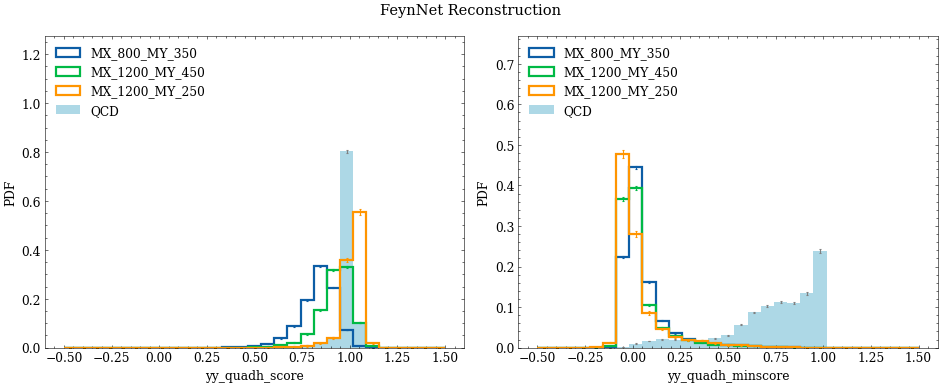

In [22]:
study.quick(
    eightb_signal[extrema_signal]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    efficiency=True,
    lumi=None,
    # **study.auroc,
)

In [23]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='Leading Y Boson Mass (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='Subleading Y Boson Mass (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='Leading Y\'s Subleading Higgs Boson Mass (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Leading Higgs Boson Mass (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='Subleading Y\'s Subleading Higgs Boson Mass (GeV)')


100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


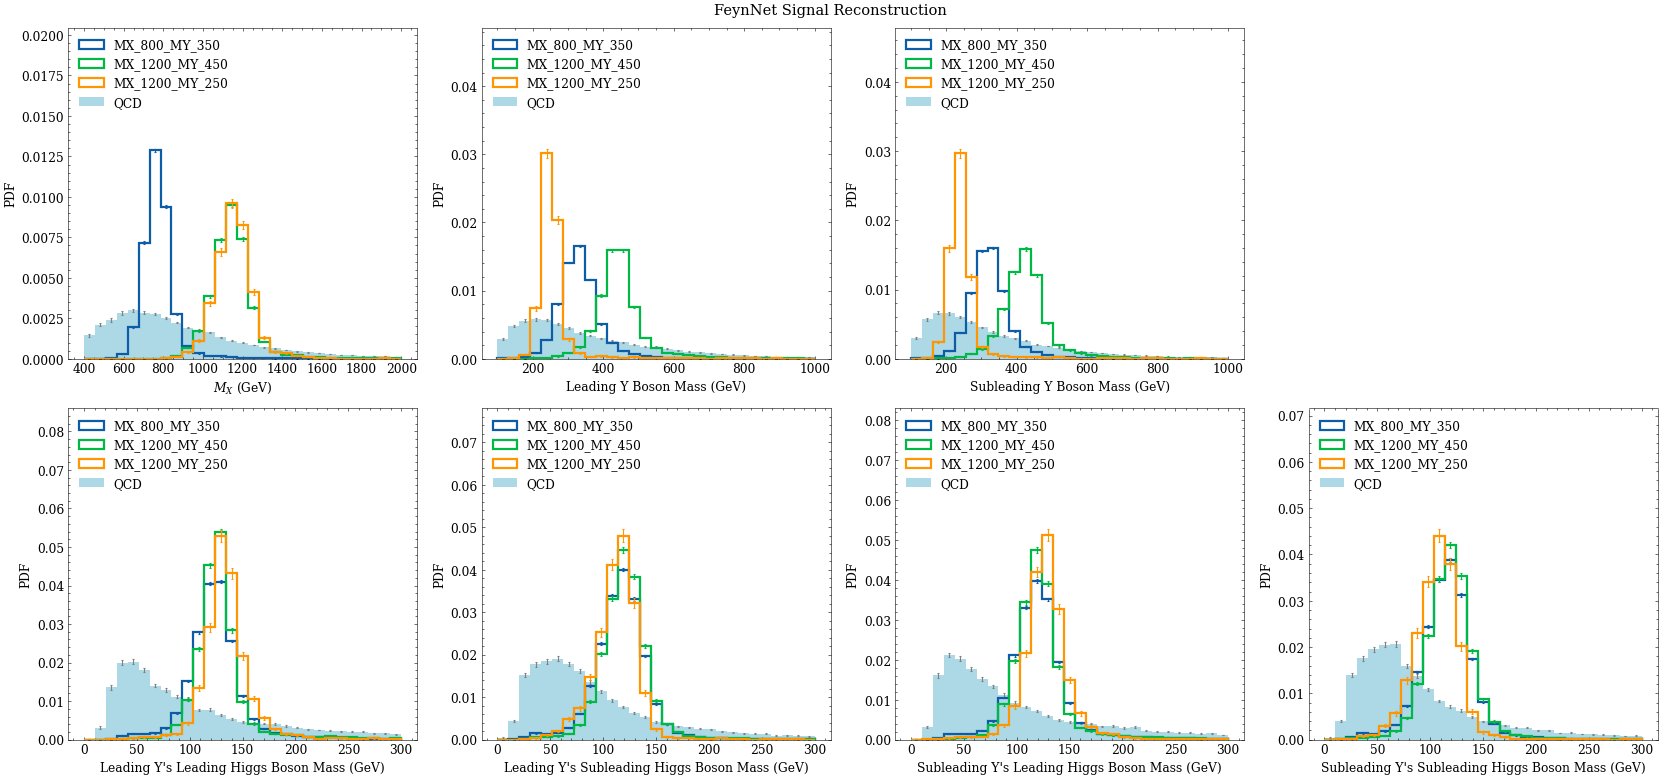

In [25]:
study.quick(
    eightb_signal[[7, 30, 26]]+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


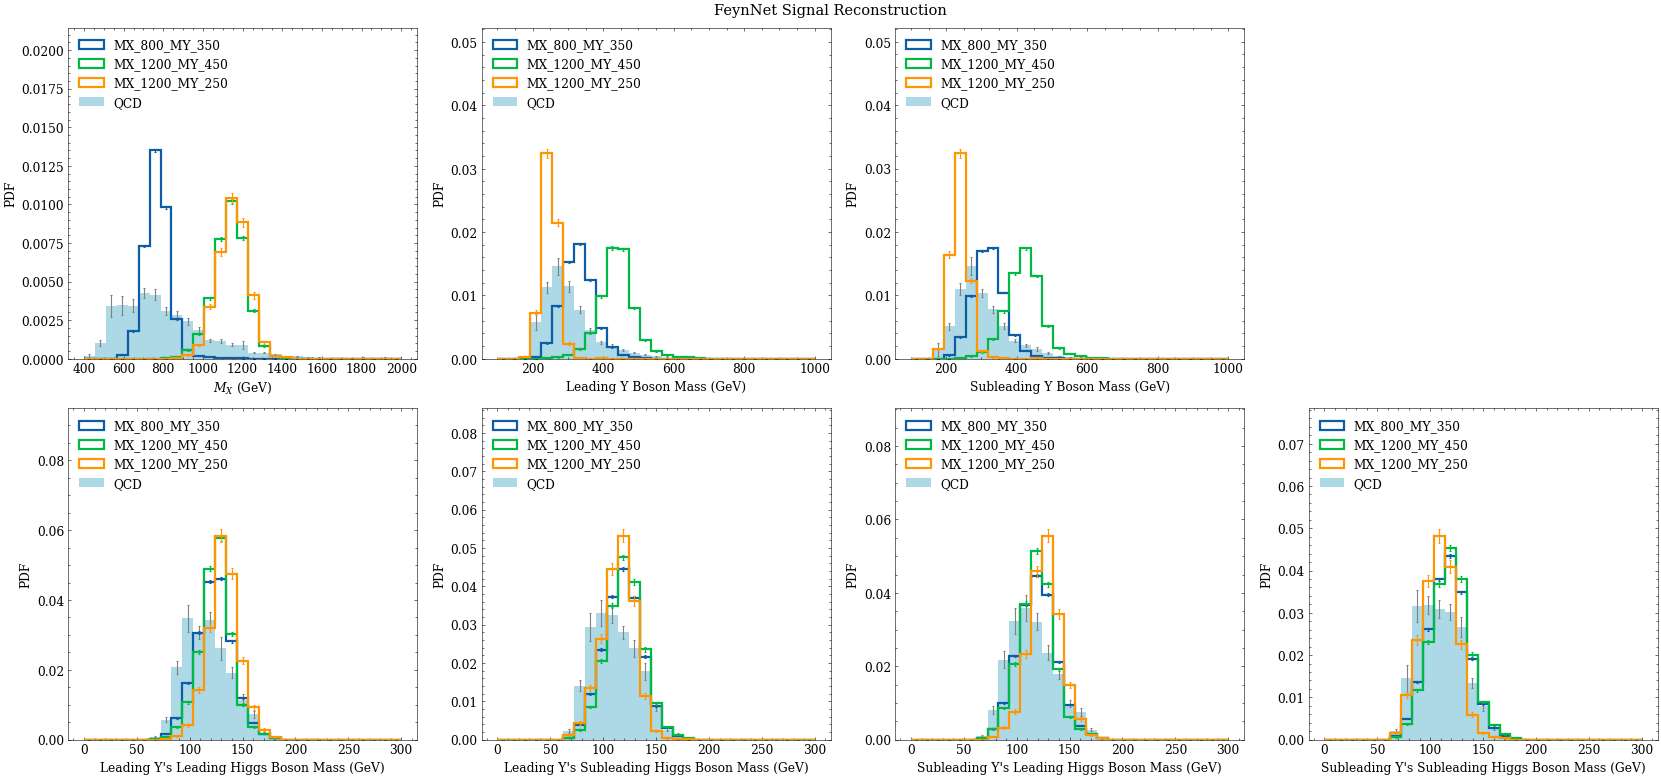

In [28]:
study.quick(
    eightb_signal[[7, 30, 26]]+bkg,
    masks=lambda t : np.sqrt( ak.sum((t.higgs_m-125)**2,axis=1) ) < 125/2,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Signal Reconstruction',
    lumi=None,
    density=True,
)